# Benchmarking 2D / 3D PORTRAITS + Correlation diagrams + Correlation factors 
--------

In [1]:
# import
from multidimvis_main import *

### TOY NETWORKS

In [6]:
# TREE GRAPH
organism = 'tree'
n = 500 # number of nodes
r = 50 # branching factor
G = nx.full_rary_tree(r, n)

# STAR GRAPH
#organism = 'star'
#n = 1000
#G = nx.star_graph(n)

# CYCLE GRAPH
#organism = 'cycle'
#n = 1000
#G = nx.cycle_graph(n)

### GEOMETRIES 

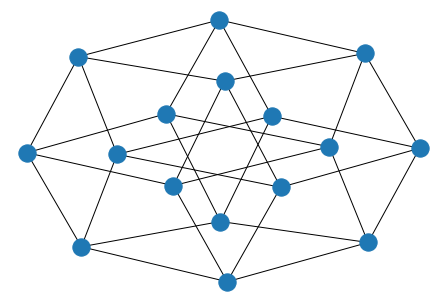

In [12]:
# Torus 
organism = 'torus'
torus_edges = [(0,1),(1,2),(2,3),(3,0),(1,5),(2,6),(0,4),(3,7),
               (4,5),(5,6),(6,7),(7,4),(5,9),(6,10),(4,8),(7,11),
              (8,9),(9,10),(10,11),(8,11),(11,15),(8,12),(9,13),(10,14),
              (12,13),(13,14),(14,15),(15,12),(12,0),(13,1),(14,2),(15,3)]
G_torus = nx.Graph()
G_torus.add_edges_from(torus_edges)
nx.draw(G_torus)

G = G_torus

In [6]:
# 3D cube
organism = '3Dcube'

cube_edges = [(0,1),(0,2),(2,3),(1,3),(2,6),(3,7),(6,7),(5,7),(1,5),(4,5),(4,0),(6,4)]
G_cube = nx.Graph()
G_cube.add_edges_from(cube_edges)

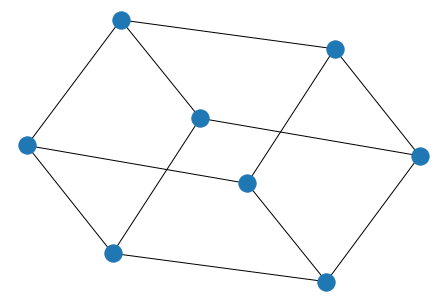

In [7]:
nx.draw(G_cube)

## NETWORK

In [7]:
print('Number of nodes i.e. genes: %s' %len(list(G.nodes())))
print('Number of edges: %s' %len(list(G.edges())))
print('Network density: %.1f%%' %(200.*len(list(G.edges()))/(len(list(G.nodes()))*len(list(G.nodes()))-1)))

Number of nodes i.e. genes: 500
Number of edges: 499
Network density: 0.4%


+ Feature Collection 

In [8]:
# DEGREE CENTRALITY - Node degree: important nodes being involved within high number of interactions
degs = dict(G.degree())
d_deghubs = {}
for node, de in sorted(degs.items(),key = lambda x: x[1], reverse = 1):
    d_deghubs[node] = round(float(de/max(degs.values())),4)
    
# CLOSENESS CENTRALITY - Measures how closely a node is connected to all other nodes to highlight f.ex. core-periphery structure, or identify central nodes
closeness = nx.closeness_centrality(G)
d_clos = {}
for node, cl in sorted(closeness.items(), key = lambda x: x[1], reverse = 1):
    d_clos[node] = round(cl,4)
    
# BETWEENESS CENTRALITY - How many shortest paths between pairs of other nodes in the network go through one node. High BC indicates "bottleneck nodes" in the network
betweens = nx.betweenness_centrality(G)
d_betw = {}
for node, be in sorted(betweens.items(), key = lambda x: x[1], reverse = 1):
     d_betw[node] = round(be,4)
    
# EIGENVECTOR CENTRALITY - Compute the eigenvector centrality for the graph
eigen = nx.eigenvector_centrality(G)
d_eigen = {}
for node, eig in sorted(eigen.items(), key = lambda x: x[1], reverse = 1):
     d_eigen[node] = round(eig,4)

In [9]:
d_deghubs_sorted = {key:d_deghubs[key] for key in sorted(d_deghubs.keys())}
d_clos_sorted = {key:d_clos[key] for key in sorted(d_clos.keys())}
d_betw_sorted = {key:d_betw[key] for key in sorted(d_betw.keys())}
d_eigen_sorted = {key:d_eigen[key] for key in sorted(d_eigen.keys())}

# feature collection
feature_dict = dict(zip(d_deghubs_sorted.keys(), zip(
                                                     d_deghubs_sorted.values(), 
                                                     d_clos_sorted.values(), 
                                                     d_betw_sorted.values(), 
                                                     d_eigen_sorted.values(),
                                                    )))

# IMPORTANT :
# sort all feature according to Graph node IDs
feature_dict_sorted = {key:feature_dict[key] for key in G.nodes()}
feature_df = pd.DataFrame.from_dict(feature_dict_sorted, orient = 'index', columns = ['degs', 
                                                                                      'clos', 
                                                                                      'betw', 
                                                                                      'eigen',
                                                                                      ]) 

In [10]:
feature_df.head()

,degs,clos,betw,eigen
0,0.9804,0.5264,0.9080,0.5006
1,1.0000,0.3707,0.1905,0.1997
2,1.0000,0.3707,0.1905,0.1997
3,1.0000,0.3707,0.1905,0.1997
4,1.0000,0.3707,0.1905,0.1997


+ Matrices

In [11]:
# Adjacency
A = nx.adjacency_matrix(G)
adj = A.toarray()
DM_adj = pd.DataFrame(adj, columns = list(G.nodes()), index=list(G.nodes()))

In [12]:
DM_adj.head() 

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
r = .8 # restart probability; originally 0.8
alpha = 1.0

DM_m = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))

DM_m_df = pd.DataFrame(DM_m)
# DM_m_df.sum(axis=0)

DM_m_transposed = DM_m_df.T
DM_m_transposed.index = list(G.nodes())

metric = "cosine" 
DM_m_new = pd.DataFrame(distance.squareform(distance.pdist(DM_m_transposed, metric)))

DM_m = pd.DataFrame(DM_m_new, columns = list(G.nodes()), index=list(G.nodes()))

In [14]:
DM_m.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.000000,0.991782,0.991782,0.991782,0.991782,0.991782,0.991782,0.991782,0.991782,0.991701,...,0.998293,0.998293,0.998293,0.998293,0.998293,0.998293,0.998293,0.998293,0.998293,0.998293
1,0.991782,0.000000,0.999950,0.999950,0.999950,0.999950,0.999950,0.999950,0.999950,0.999949,...,0.999990,0.999990,0.999990,0.999990,0.999990,0.999990,0.999990,0.999990,0.999990,0.999990
2,0.991782,0.999950,0.000000,0.999950,0.999950,0.999950,0.999950,0.999950,0.999950,0.999949,...,0.999990,0.999990,0.999990,0.999990,0.999990,0.999990,0.999990,0.999990,0.999990,0.999990
3,0.991782,0.999950,0.999950,0.000000,0.999950,0.999950,0.999950,0.999950,0.999950,0.999949,...,0.999990,0.999990,0.999990,0.999990,0.999990,0.999990,0.999990,0.999990,0.999990,0.999990
4,0.991782,0.999950,0.999950,0.999950,0.000000,0.999950,0.999950,0.999950,0.999950,0.999949,...,0.999990,0.999990,0.999990,0.999990,0.999990,0.999990,0.999990,0.999990,0.999990,0.999990


In [15]:
metric = "cosine" 
DM_cent = pd.DataFrame(distance.squareform(distance.pdist(feature_df, metric)))

In [16]:
DM_cent.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.000000,0.135517,0.135517,0.135517,0.135517,0.135517,0.135517,0.135517,0.135517,0.135953,...,0.582196,0.582196,0.582196,0.582196,0.582196,0.582196,0.582196,0.582196,0.582196,0.582196
1,0.135517,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000030,...,0.585053,0.585053,0.585053,0.585053,0.585053,0.585053,0.585053,0.585053,0.585053,0.585053
2,0.135517,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000030,...,0.585053,0.585053,0.585053,0.585053,0.585053,0.585053,0.585053,0.585053,0.585053,0.585053
3,0.135517,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000030,...,0.585053,0.585053,0.585053,0.585053,0.585053,0.585053,0.585053,0.585053,0.585053,0.585053
4,0.135517,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000030,...,0.585053,0.585053,0.585053,0.585053,0.585053,0.585053,0.585053,0.585053,0.585053,0.585053


In [17]:
feature = 'adj'
DM = DM_adj

#feature = 'rwr'
#DM = DM_m

#feature = 'cent'
#DM = DM_cent

____________
# 3 | SET VISUAL PRE-SETTINGS
____________

### GENERAL NODE + EDGE PARAMETERS

In [45]:
# Node, Edge colors

edge_width = 2
edge_col = 'lightgrey'
edge_colordark = 'dimgrey'
opacity_edges = 1

opacity_nodes = 1.0
node_edge_col = None


# Node sizes 

scalef= 0.2
size = list(draw_node_degree(G, scalef).values())

scalef= 0.05
size3d = list(draw_node_degree_3D(G, scalef).values())

### SPECIFIC NODE + EDGE PARAMETERS

In [19]:
# ----------------------------------------------------        
# Define colour parameter with dict (gradient)
# ----------------------------------------------------        
color_method = 'degree'
d_to_be_coloured = d_deghubs # dict sorted by dict.values (that way the biggest value matches darkest colour of palette)


# Colouring
colour_groups = set(d_to_be_coloured.values())
colour_count = len(colour_groups)
pal = sns.color_palette('Reds', colour_count)
palette = pal.as_hex()

d_colourgroups = {}
for n in colour_groups:
    d_colourgroups[n] = [k for k in d_to_be_coloured.keys() if d_to_be_coloured[k] == n]
    
d_colourgroups_sorted = {key:d_colourgroups[key] for key in sorted(d_colourgroups.keys())}

d_val_col = {}
for idx,val in enumerate(d_colourgroups_sorted):
    for ix,v in enumerate(palette):
        if idx == ix:
            d_val_col[val] = v
d_node_colour = {}
for y in d_to_be_coloured.items(): # y[0] = node id, y[1] = val
    for x in d_val_col.items(): # x[0] = val, x[1] = (col,col,col)
        if x[0] == y[1]:
            d_node_colour[y[0]]=x[1]
            
# SORT dict based on G.nodes
d_node_colour_sorted = dict([(key, d_node_colour[key]) for key in G.nodes()])

l_col_clos = list(d_node_colour_sorted.values())

colours_hex = l_col_clos 


d_val_col = {}
for idx,val in enumerate(d_colourgroups_sorted):
    for ix,v in enumerate(pal):
        if idx == ix:
            d_val_col[val] = v
d_node_colour = {}
for y in d_to_be_coloured.items(): # y[0] = node id, y[1] = val
    for x in d_val_col.items(): # x[0] = val, x[1] = (col,col,col)
        if x[0] == y[1]:
            d_node_colour[y[0]]=x[1]
            
# SORT dict based on G.nodes
d_node_colour_sorted = dict([(key, d_node_colour[key]) for key in G.nodes()])

l_col = list(d_node_colour_sorted.values())
colours = l_col

# 2D PORTRAITS

### SPRING

In [20]:
%%time 

# ---------------------------------------
# Spring
# ---------------------------------------
forceatlas2 = ForceAtlas2()
#posG_spring = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=200)
posG_spring2D = nx.spring_layout(G, dim = 2)
posG_spring3D = nx.spring_layout(G, dim = 3)

CPU times: user 3.67 s, sys: 10.2 ms, total: 3.68 s
Wall time: 3.68 s


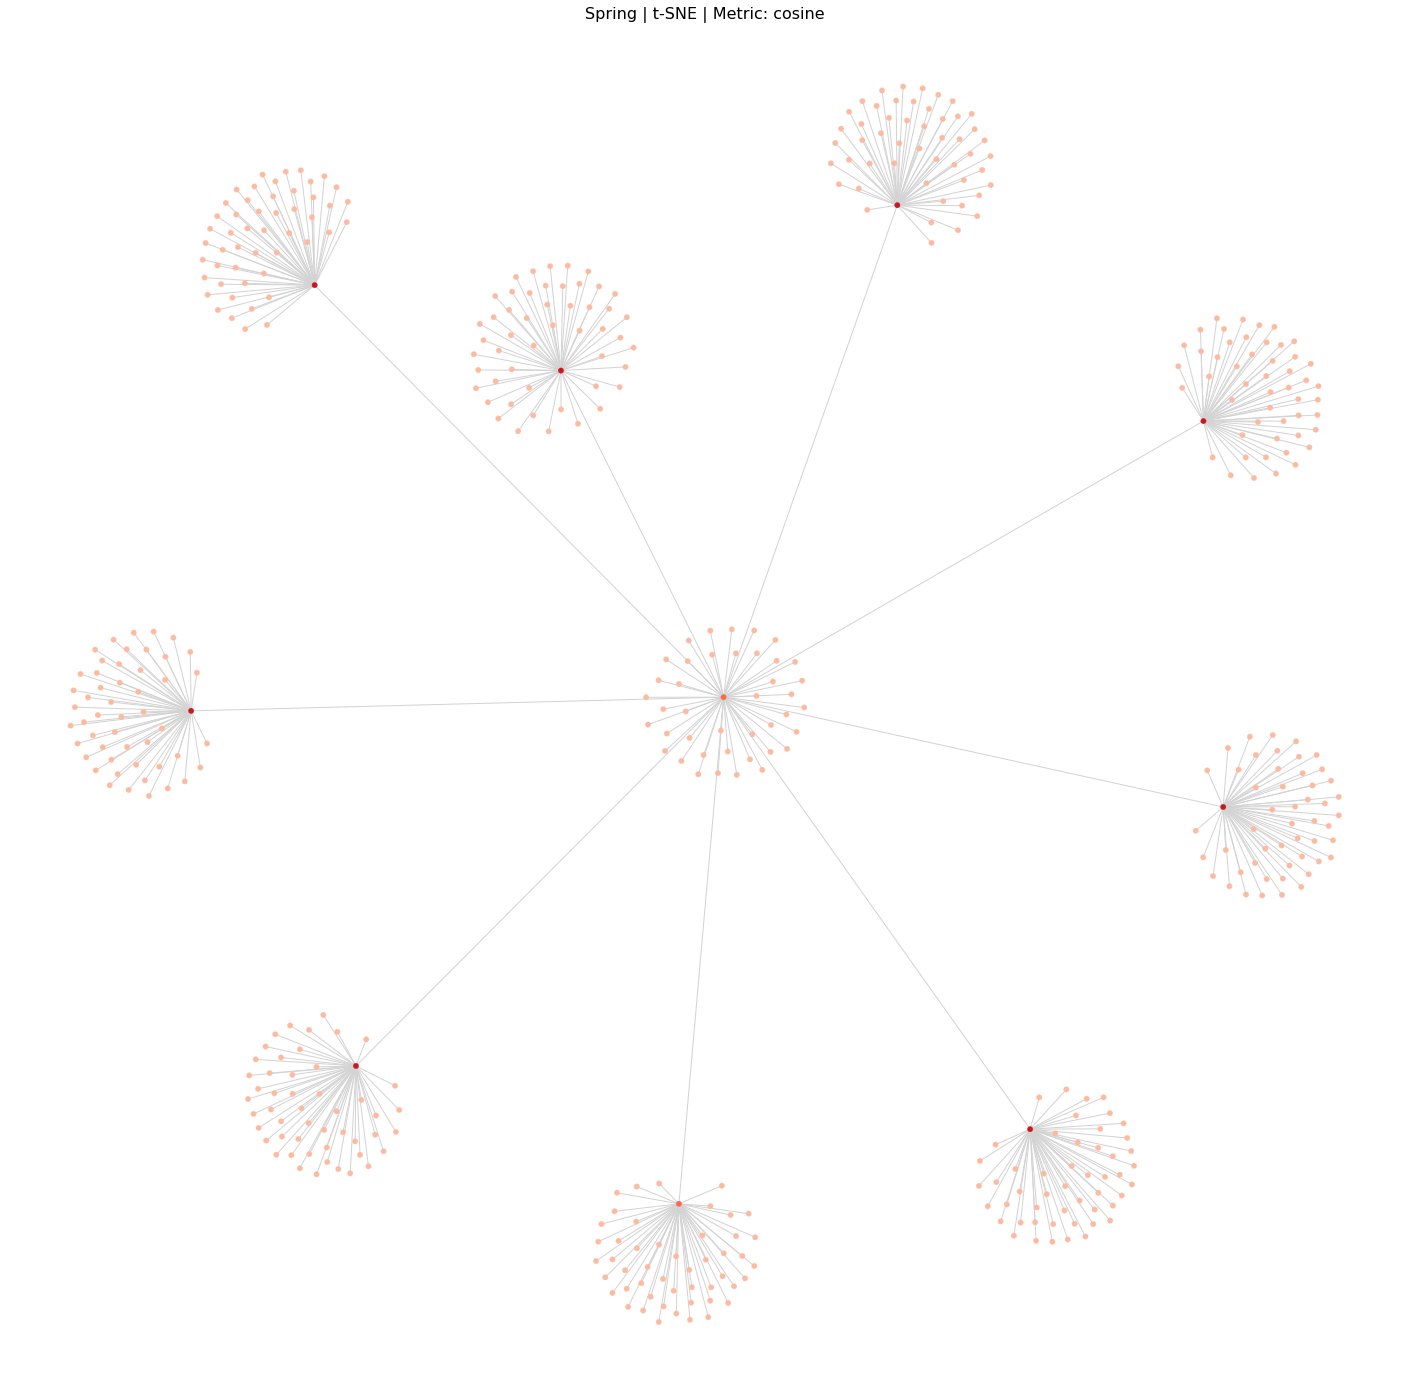

In [21]:
plt.figure(figsize=(25,25))
plt.title('Spring | t-SNE | Metric: '+metric, size= 16)

nx.draw_networkx_nodes(G, posG_spring2D, edgecolors = node_edge_col, linewidths = 0.25, node_color = colours, 
                       node_size= 30, #size, 
                       alpha = opacity_nodes)
nx.draw_networkx_edges(G, posG_spring2D, width = edge_width, edge_color = edge_col, alpha = opacity_edges)

plt.box(False)

plt.savefig('output_plots/2Dspring.png')

plt.show()

### TSNE

In [273]:
prplxty = 200 # range: 5-50 / default = 30
density = 1.  # default 12.
l_rate = 1000 #default 200.
steps = 500 # min 250

metric = 'cosine'

In [274]:
%%time 
tsne = embed_tsne_2D(DM, prplxty, density, l_rate, steps, metric)

CPU times: user 2.59 s, sys: 172 ms, total: 2.76 s
Wall time: 474 ms


In [275]:
posG_tsne = get_posG_2D(list(G.nodes()), tsne)
posG_complete_tsne = {key:posG_tsne[key] for key in G.nodes()}

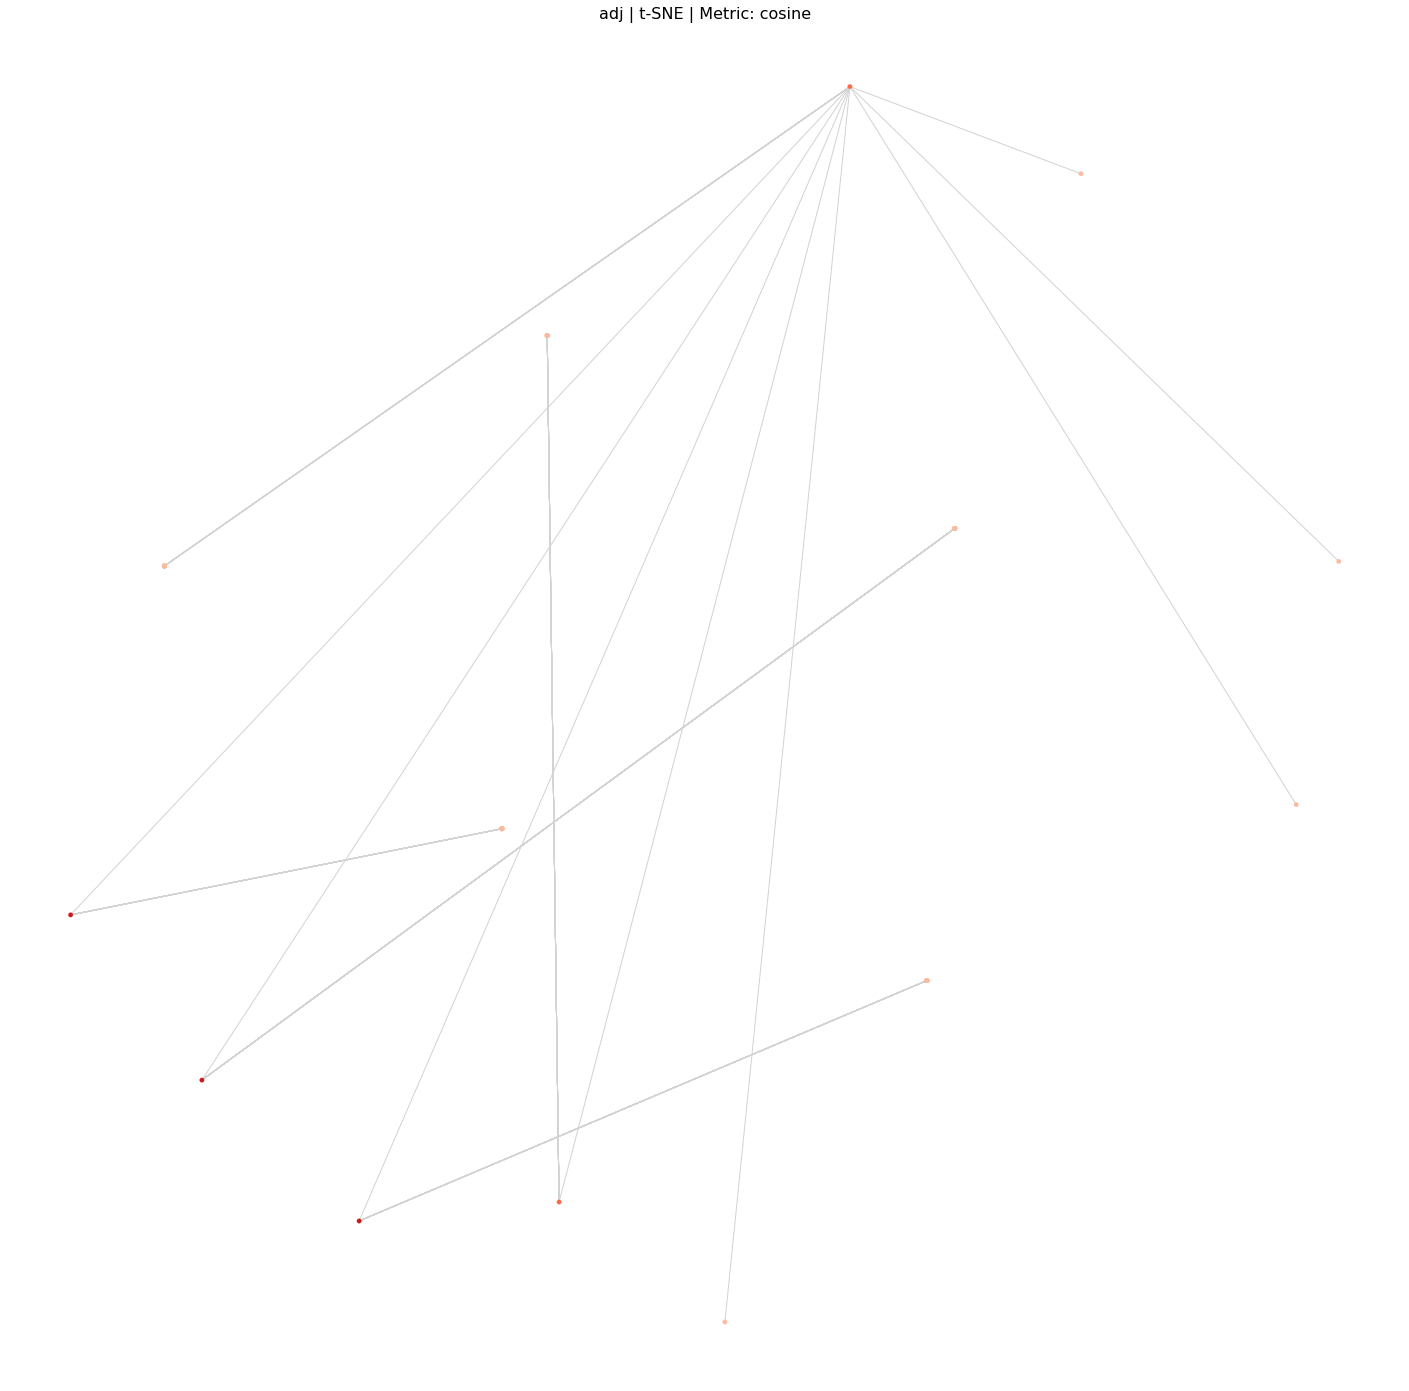

In [283]:
plt.figure(figsize=(25,25))
plt.title(feature+' | t-SNE | Metric: '+metric, size= 16)

nx.draw_networkx_nodes(G, posG_complete_tsne, edgecolors = node_edge_col, linewidths = 0.25, node_color = colours, 
                       node_size= 20, #size, 
                       alpha = opacity_nodes)
nx.draw_networkx_edges(G, posG_complete_tsne, width = edge_width, edge_color = edge_col, alpha = opacity_edges)

plt.box(False)

plt.savefig('output_plots/2Dtoynetworktsne_'+feature+'_'+metric+'_'+str(prplxty)+'_'+str(density)+'_'+str(l_rate)+'_'+str(steps)
        +'_'+organism+'_'+color_method+'_nx.png')

plt.show()

### UMAP 

In [22]:
n_neighbors = 20 # balance between local and global structure in the data
spread = 50
min_dist = 0.1 # defines how dense points are stacked together 
metric ='cosine'

In [23]:
%%time 
umap = embed_umap_2D(DM, n_neighbors, spread, min_dist, metric)

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



CPU times: user 13.2 s, sys: 502 ms, total: 13.7 s
Wall time: 7.43 s


In [24]:
posG_umap = get_posG_2D(G.nodes(), umap)
posG_complete_umap = {key:posG_umap[key] for key in G.nodes()}

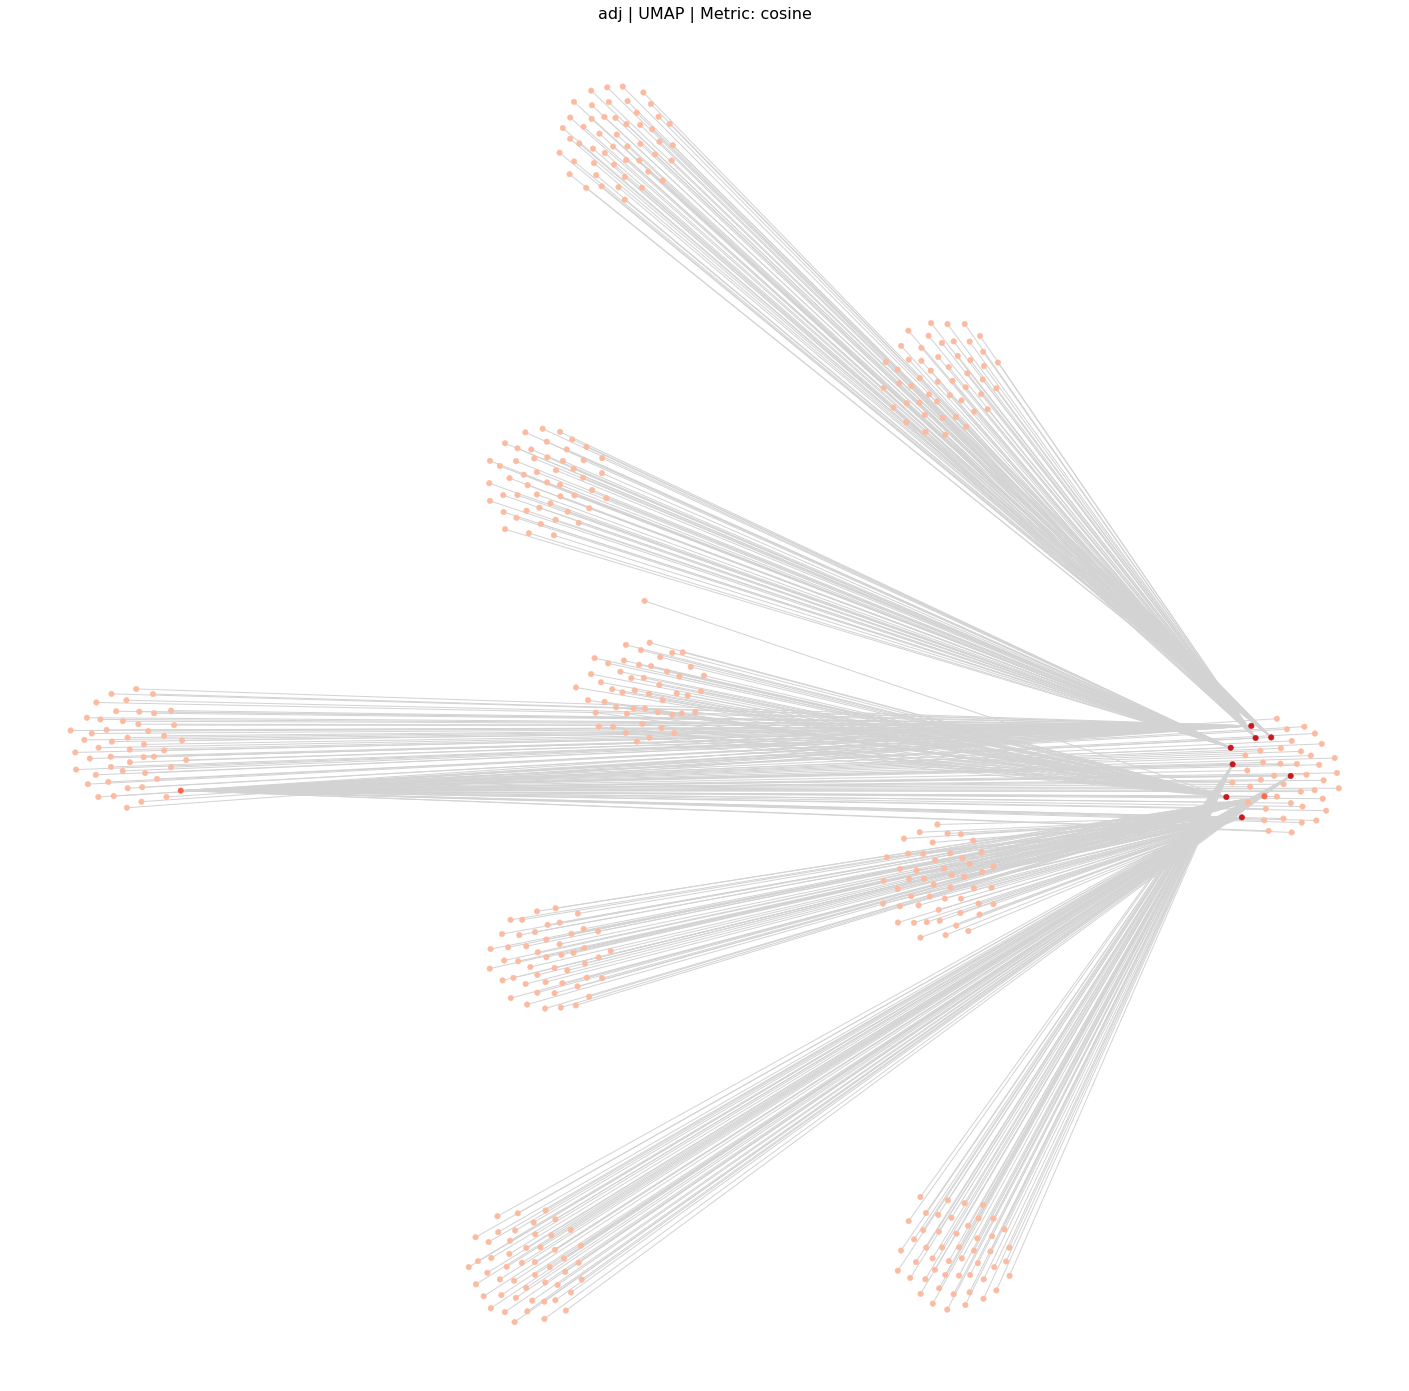

In [25]:
plt.figure(figsize=(25,25))
plt.title(feature+' | UMAP | Metric: '+metric, size=16)

nx.draw_networkx_nodes(G, posG_complete_umap, edgecolors = node_edge_col, linewidths = 0.5, node_color=colours, 
                       node_size = 30, #size, 
                       alpha = opacity_nodes)
nx.draw_networkx_edges(G, posG_complete_umap, width = edge_width, edge_color = edge_col, alpha = opacity_edges)
plt.box(False)

plt.savefig('output_plots/2Dtoynetworkumap_'+feature+'_'+metric+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'.png')

plt.show()

# 3D SPRING

In [49]:
spring_nodes = get_trace_nodes_3D(posG_spring3D, None, colours, 4) #size3d)
spring_edges = get_trace_edges_3D(G, posG_spring3D, edge_col, opac=1)

spring_data = [spring_nodes, spring_edges]

Spring Layout: tree


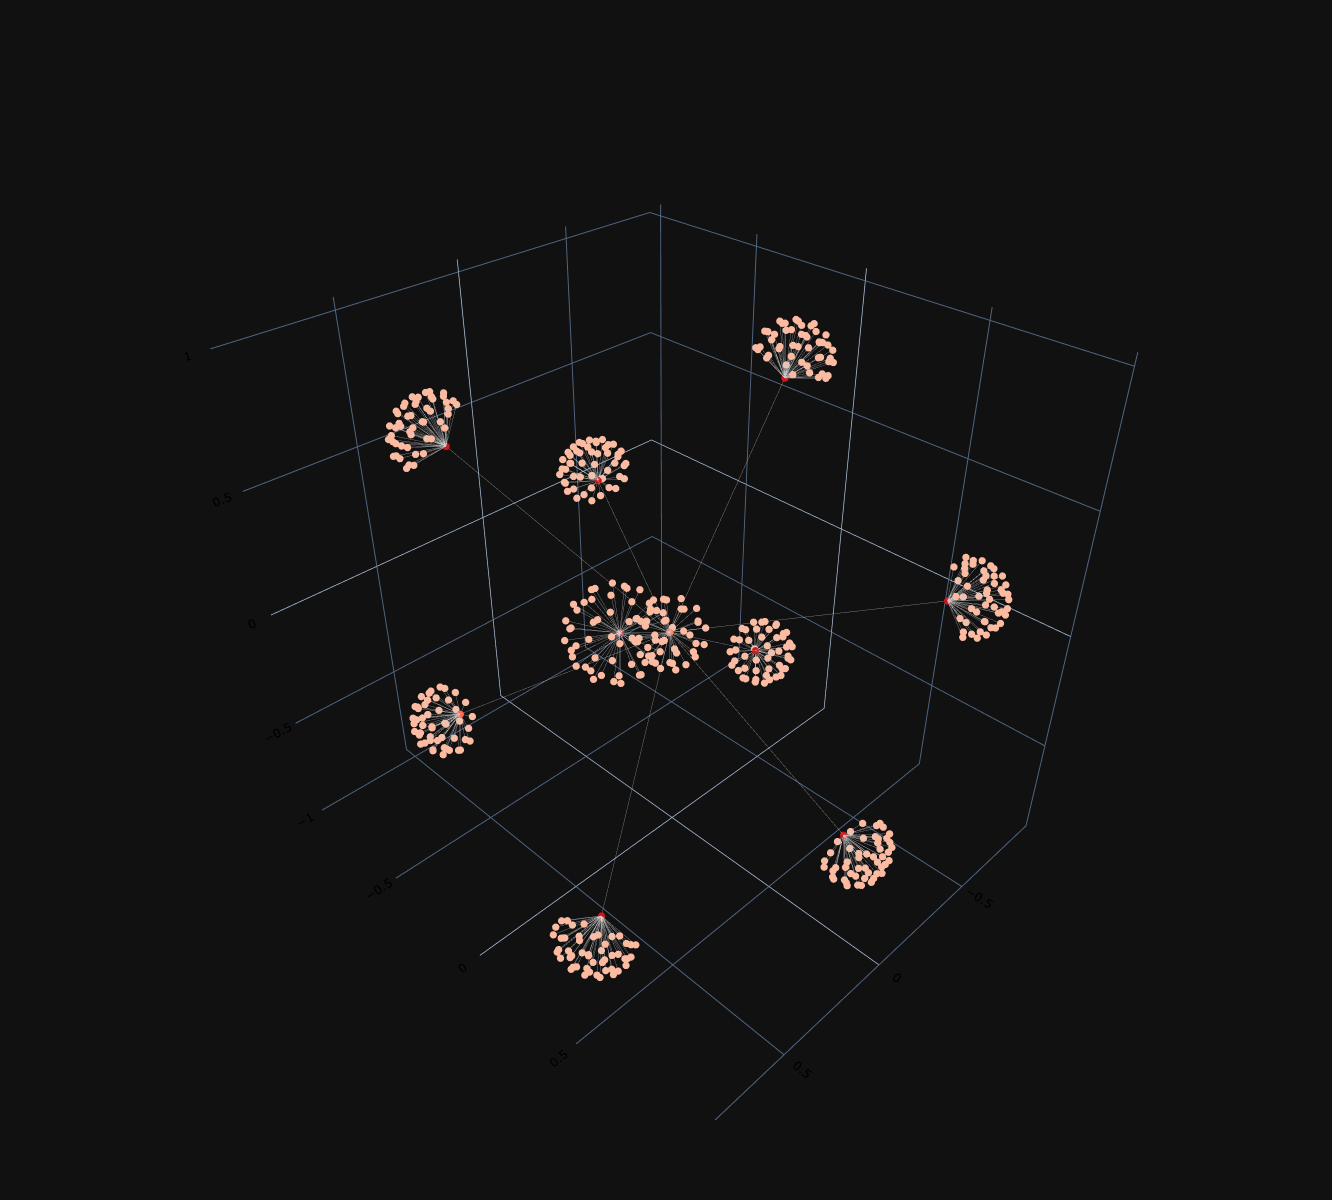

'output_plots/3Dtoynetwork_spring_tree.html'

In [50]:
print('Spring Layout:', organism)

fig = pgo.Figure()
for i in spring_data:
    fig.add_trace(i)
fig.update_layout(template='plotly_dark', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                    dragmode="turntable",
                    #annotations=annotations,
                ))
py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/3Dtoynetwork_'+'spring_'+organism+'.html', auto_open=False)

# 3D PORTRAITS

### TSNE

In [177]:
prplxty3d = 50 # range: 5-50 / default = 30.#
density3d = 1.0 # default 12.
l_rate3d = 200 # default 200.
steps3d = 250 #min 250

metric = 'cosine'

In [178]:
%%time
tsne_3D = embed_tsne_3D(DM, prplxty3d, density3d, l_rate3d, steps3d)

CPU times: user 923 ms, sys: 64.4 ms, total: 987 ms
Wall time: 178 ms


In [179]:
posG_3Dtsne = get_posG_3D(list(G.nodes()), tsne_3D)
posG_3D_complete_tsne = {key:posG_3Dtsne[key] for key in G.nodes()}

In [180]:
tsne_nodes = get_trace_nodes_3D(posG_3D_complete_tsne, None, colours, 4) #size3d)
tsne_edges = get_trace_edges_3D(G, posG_3D_complete_tsne, edge_col, 1.0)

tsne_data = [tsne_nodes, tsne_edges]
#tsne_data = [tsne_nodes]

In [181]:
print('Perplexity:', prplxty3d)
print('Early Exaggeration:', density3d)
print('Learning rate:', l_rate3d)
print('Iterations:', steps3d)

fig = pgo.Figure()
for i in tsne_data:
    fig.add_trace(i)
fig.update_layout(template='plotly_dark', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                    dragmode="turntable",
                    #annotations=annotations,
                ))
#py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/3Dtoynetwork_tsne_'+feature+'_'+metric+'_'+str(prplxty)+'_'+str(density)+'_'+str(l_rate)+'_'+str(steps)+'_'+organism+'_'+color_method+'.html', auto_open=True)

Perplexity: 50
Early Exaggeration: 1.0
Learning rate: 200
Iterations: 250


'output_plots/3Dtoynetwork_tsne_adj_cosine_200_1.0_1000_500_tree_degree.html'

### UMAP 

In [51]:
n_neighbors = 20 # balance between local and global structure in the data
spread = 100
min_dist = 0.1 # defines how dense points are stacked together 
metric='cosine'

In [52]:
%%time 
umap_3D = embed_umap_3D(DM, n_neighbors, spread, min_dist, metric)

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1158: RuntimeWarning:

divide by zero encountered in power



CPU times: user 9.98 s, sys: 233 ms, total: 10.2 s
Wall time: 3.38 s


In [53]:
posG_3Dumap = get_posG_3D(list(G.nodes()), umap_3D)
posG_3D_complete_umap = {key:posG_3Dumap[key] for key in G.nodes()}

In [56]:
%%time 
umap_nodes = get_trace_nodes_3D(posG_3D_complete_umap, None, colours, 2) # size3d)
umap_edges = get_trace_edges_3D(G, posG_3D_complete_umap, edge_col, 0.3) 

umap_data = [umap_edges, umap_nodes]
#umap_data = [umap_nodes]

CPU times: user 35.9 ms, sys: 2.68 ms, total: 38.6 ms
Wall time: 37.4 ms


In [57]:
fig = pgo.Figure()
for i in umap_data:
    fig.add_trace(i)

fig.update_layout(template='plotly_dark', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='black')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='black')),    
                    dragmode="turntable",
                    #annotations=annotations,
                ))    

#py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/3Dtoynetwork_umap_'+feature+'_'+organism+'.html', auto_open=True)

'output_plots/3Dtoynetwork_umap_adj_tree.html'

_________

# EVALUATION OF Layouts compared to Spring
### CALCULATE DISTANCES OF NODES IN LAYOUTS
+ Plots to test "Original Distances" with embedded Distances 
+ X-axis = distances of layout, Y-axis = actual Distance Matrix Distances

In [58]:
def calc_dist_2D(posG):
    
    l_x= []
    l_y=[]
    for coords in posG.values():
            l_x.append(coords[0])
            l_y.append(coords[1])
            
    p_dist = []
    for idx,val in enumerate(l_x):
        d_list = []
        for c in range(len(l_x)):
            for yy in l_y:
                d = np.sqrt((l_x[idx]-l_x[c])**2+(l_y[idx]-l_y[c])**2)
            d_list.append(d)
        p_dist.append(d_list)
        
    return p_dist


def calc_dist_3D(posG):
    
    l_x = []
    l_y = []
    l_z = []
    for coords in posG.values():
            l_x.append(coords[0])
            l_y.append(coords[1])
            l_z.append(coords[2])
            
    p_dist = []
    for idx,val in enumerate(l_x):
        d_list = []
        for c in range(len(l_x)):
            d = np.sqrt((l_x[idx]-l_x[c])**2+(l_y[idx]-l_y[c])**2+(l_z[idx]-l_z[c])**2)
        d_list.append(d)
    p_dist.append(d_list)
        
    return p_dist

In [59]:
'''
Get trace 2D.
Used for distance functions (2D; benchmarking) 
'''
def get_trace_xy(x,y,trace_name,colour):
    trace = pgo.Scatter(
        name = trace_name,
    x = x,
    y = y,
    mode='markers',
    marker=dict(
        size=3,
        color=colour
    ),)
    return trace



'''
Generate 3D trace. 
Used for distance functions (3D; benchmarking)
''' 
def get_trace_xyz(x,y,z,trace_name,colour):
    
    
    trace = pgo.Scatter3d(
        x = x,
        y = y,
        z = z,
        mode='markers',
        text=trace_name,
        marker=dict(
            size=3,
            color=colour, 
            line_width=0.5,
            line_color = colour,
        ),)
    return trace

## 2D layouts Correlation diagrams 

In [60]:
%%time 

# Distance from embeded Spring layout 
dist_coordinates_spring = calc_dist_2D(posG_spring2D)

# Distances from embeded coordinates from matrices 
dist_coordinates_layout = calc_dist_2D(posG_complete_umap)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/chris/opt/anaconda3/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1315, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "<ipython-input-58-5fb09f7354d5>", line 14, in calc_dist_2D
    d = np.sqrt((l_x[idx]-l_x[c])**2+(l_y[idx]-l_y[c])**2)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/chris/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/chris/opt/anaconda3/lib/python3.8/site-packages/IPython/core/ultratb.py", line 1169, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_cont

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/chris/opt/anaconda3/lib/python3.8/site-packages/IPython/core/magics/execution.py", line 1315, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 5, in <module>
  File "<ipython-input-58-5fb09f7354d5>", line 14, in calc_dist_2D
    d = np.sqrt((l_x[idx]-l_x[c])**2+(l_y[idx]-l_y[c])**2)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/chris/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/chris/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
 

TypeError: object of type 'NoneType' has no len()

In [ ]:
spring_trace = [] 
for i in range(len(dist_coordinates_spring)):
    spring_trace.append(get_trace_xy(dist_coordinates_spring[i], DM[i], "Spring", "darkgrey"))

layout_trace = []
for i in range(len(dist_coordinates_layout)):
    layout_trace.append(get_trace_xy(dist_coordinates_layout[i], DM[i], feature, "coral"))

data = [
    spring_trace, 
    layout_trace]

In [ ]:
# regression line SPRING

X_spring = dist_coordinates_spring[0]
Y_spring = DM[0]
df_spring = pd.DataFrame({'X': X_spring, 'Y':Y_spring})

reg = LinearRegression().fit(np.vstack(df_spring['X']), Y_spring)
df_spring['bestfit'] = reg.predict(np.vstack(df_spring['X']))


# regression line LAYOUT
from sklearn.linear_model import LinearRegression

X = dist_coordinates_layout[0]
Y = DM[0]
df = pd.DataFrame({'X': X, 'Y':Y})

reg = LinearRegression().fit(np.vstack(df['X']), Y)
df['bestfit'] = reg.predict(np.vstack(df['X']))

In [ ]:
print('Initial Benchmarking model (Organism):', organism)

fig = pgo.Figure()
for i in data:
    for j in i:
        fig.add_trace(j)
        
# regression line 
fig.add_trace(pgo.Scatter(name='line of best fit', x=X, y=df['bestfit'], 
                          mode='lines',
                          line=dict(
                             color='red',
                             width=0.5
            ),))

fig.add_trace(pgo.Scatter(name='line of best fit', x=X_spring, y=df_spring['bestfit'], 
                          mode='lines',
                          line=dict(
                             color='dimgrey',
                             width=0.5
            ),))


fig.update_layout(template='plotly_white', showlegend=False, width=600, height = 600
                )    

#py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/2Dtoynetwork_umap_'+feature+'_'+organism+'.html', auto_open=False)

## 3D layouts Correlation diagrams

In [102]:
# Distance from embeded Spring layout 
dist_coordinates_spring = calc_dist_3D(posG_spring3D)

# Distances from embeded coordinates from matrices 
dist_coordinates_layout = calc_dist_3D(posG_3D_complete_umap)

In [103]:
dist_coordinates_spring

[[0.0]]

In [75]:
# ADJ 
spring_adjtrace = [] 
for i in range(len(dist_spring)):
    spring_adjtrace.append(get_trace(dist_spring[i], DM_adj[i], "Spring", "darkgrey"))

adj_trace = []
for i in range(len(dist_adj)):
    adj_trace.append(get_trace(dist_adj[i], DM_adj[i], "Aij", "coral"))

data_adj = [
    spring_adjtrace, 
    adj_trace]


# SPL
spring_spltrace = [] 
for i in range(len(dist_spring)):
    spring_spltrace.append(get_trace(dist_spring[i], DM_spl[i], "Spring", "darkgrey"))

spl_trace = []
for i in range(len(dist_spring)):
    spl_trace.append(get_trace(dist_spl[i], DM_spl[i], "SPL", "darkorange"))

data_spl = [
    spring_spltrace, 
    spl_trace]


# MARKOV
spring_mtrace = [] 
for i in range(len(dist_spring)):
    spring_mtrace.append(get_trace(dist_spring[i], DM_m_mod[i], "Spring", "darkgrey"))

m_trace = []
for i in range(len(dist_spring)):
    m_trace.append(get_trace(dist_m[i], DM_m_mod[i], "Markov", "chocolate"))

data_m = [
    spring_mtrace, 
    m_trace]


# -log MARKOV
spring_mlogtrace = [] 
for i in range(len(dist_spring)):
    spring_mlogtrace.append(get_trace(dist_spring[i], DM_mlog[i], "Spring", "darkgrey"))

mlog_trace = []
for i in range(len(dist_spring)):
    mlog_trace.append(get_trace(dist_mlog[i], DM_mlog[i], "-log Markov", "orangered"))

data_mlog = [
    spring_mlogtrace, 
    mlog_trace]


# COSINE
spring_costrace = [] 
for i in range(len(dist_spring)):
    spring_costrace.append(get_trace(dist_spring[i], DM_cos[i], "Spring", "darkgrey"))

cos_trace = []
for i in range(len(dist_spring)):
    cos_trace.append(get_trace(dist_cos[i], DM_cos[i], "Cos", "royalblue"))

data_cos = [
    spring_costrace, 
    cos_trace]


# EUCLIDEAN
spring_eucltrace = [] 
for i in range(len(dist_spring)):
    spring_eucltrace.append(get_trace(dist_spring[i], DM_eucl[i], "Spring", "darkgrey"))

eucl_trace = []
for i in range(len(dist_spring)):
    eucl_trace.append(get_trace(dist_eucl[i], DM_eucl[i], "Eucl", "navy"))

data_eucl = [
    spring_eucltrace, 
    eucl_trace]


# SQUARED EUCLIDEAN
spring_sqeucltrace = [] 
for i in range(len(dist_spring)):
    spring_sqeucltrace.append(get_trace(dist_spring[i], DM_sqeucl[i], "Spring", "darkgrey"))

sqeucl_trace = []
for i in range(len(dist_spring)):
    sqeucl_trace.append(get_trace(dist_sqeucl[i], DM_sqeucl[i], "Sq Eucl", "slategrey"))

data_sqeucl = [
    spring_sqeucltrace, 
    sqeucl_trace]


# CORRELATION
spring_corrtrace = [] 
for i in range(len(dist_spring)):
    spring_corrtrace.append(get_trace(dist_spring[i], DM_corr[i], "Spring", "darkgrey"))

corr_trace = []
for i in range(len(dist_spring)):
    corr_trace.append(get_trace(dist_corr[i], DM_corr[i], "Corr", "cornflowerblue"))

data_corr = [
    spring_corrtrace, 
    corr_trace]

NameError: name 'dist_spring' is not defined

In [ ]:
fig = make_subplots(rows = 2, cols = 4,
                    specs=2*[4 * [{'type': 'Scatter'}]],
                    print_grid=False, 
                    subplot_titles=('Aij', 
                                    'SPL',
                                    'Markov',
                                    '-log Markov',
                                   'Cosine',
                                   'Euclidean',
                                   'Squared Euclidean',
                                   'Correlation')
                   )

    
for i in data_adj:
    for j in i:
        fig.add_trace(j, row=1, col=1)
    
for i in data_spl:
    for j in i:
        fig.add_trace(j, row=1, col=2)
    
for i in data_m:
    for j in i:
        fig.add_trace(j, row=1, col=3)

for i in data_mlog:
    for j in i:
        fig.add_trace(j, row=1, col=4)
        
    
for i in data_cos:
    
    for j in i:
        fig.add_trace(j, row=2, col=1)
    
for i in data_eucl:
    for j in i:
        fig.add_trace(j, row=2, col=2)
    
for i in data_sqeucl:
    for j in i:
        fig.add_trace(j, row=2, col=3)

for i in data_corr:
    for j in i:
        fig.add_trace(j, row=2, col=4)

fig.update_xaxes(title_text = "Embedded Distances")
fig.update_yaxes(title_text = "Calculated Distances")

fig.update_layout(
    #xaxis_type="log", 
    #yaxis_type="log",
    template='none',showlegend = False,
    height=1600,
    width=1800
)

fig.write_image("output_plots/Diagram_Comparison_2D_DM_Embedded.png")

print('Number of Nodes:', len(G.nodes()))
fig.show()

# Statistical Test for correlation between data sets (DMs to Layouts): 
### Pearson Correlation
+ Pearson product-moment correlation coefficients
+ The relationship between the correlation coefficient matrix, R, and the covariance matrix, C
+ Value can range from -1 to 1, the closer to 1 the more positive linear correlation ( the closer to -1 the more negative linear correlation)

In [ ]:
# Pearson Correlation coefficient comparison of Spring- to Layouts-coordinates

print('Number of Nodes: ', len(G.nodes()))
print('')

# Aij 
pearson_spring_adj = np.corrcoef(dist_spring,DM_adj)
print('Spring: Mean of Pearson Correlation Coefficient: ',round(np.mean(pearson_spring_adj),4))

pearson_adj = np.corrcoef(dist_adj,DM_adj)
print('Aij: Mean of Pearson Correlation Coefficient: ',round(np.mean(pearson_adj),4))

print('')

# SPL
pearson_spring_spl = np.corrcoef(dist_spring,DM_spl)
print('Spring: Mean of Pearson Correlation Coefficient: ',round(np.mean(pearson_spring_spl),4))

pearson_spl = np.corrcoef(dist_spl,DM_spl)
print('SPL: Mean of Pearson Correlation Coefficient: ',round(np.mean(pearson_spl),4))

print('')

# Markov
pearson_spring_m = np.corrcoef(dist_spring, DM_m_mod)
print('Spring: Mean of Pearson Correlation Coefficient: ',round(np.mean(pearson_spring_m),4))

pearson_m = np.corrcoef(dist_m,DM_m_mod)
print('Markov: Mean of Pearson Correlation Coefficient: ',round(np.mean(pearson_m),4))

print('')
 
    
# -log Markov
pearson_spring_mlog = np.corrcoef(dist_spring,DM_mlog)
print('Spring: Mean of Pearson Correlation Coefficient: ',round(np.mean(pearson_spring_mlog),4))

pearson_mlog = np.corrcoef(dist_mlog,DM_mlog)
print('-log Markov: Mean of Pearson Correlation Coefficient: ',round(np.mean(pearson_mlog),4))

print('')


# Cos
pearson_spring_cos = np.corrcoef(dist_spring,DM_cos)
print('Spring: Mean of Pearson Correlation Coefficient: ', round(np.mean(pearson_spring_cos),4))

pearson_cos = np.corrcoef(dist_cos,DM_cos)
print('Cosine: Mean of Pearson Correlation Coefficient: ',round(np.mean(pearson_cos),4))
 
print('')


# Eucl
pearson_spring_eucl = np.corrcoef(dist_spring,DM_eucl)
print('Spring: Mean of Pearson Correlation Coefficient: ',round(np.mean(pearson_spring_eucl),4))

pearson_eucl = np.corrcoef(dist_eucl,DM_eucl)
print('Euclidean: Mean of Pearson Correlation Coefficient: ',round(np.mean(pearson_eucl),4))

print('')
  
    
# SqEucl
pearson_spring_sqeucl = np.corrcoef(dist_spring,DM_sqeucl)
print('Spring: Mean of Pearson Correlation Coefficient: ',round(np.mean(pearson_spring_sqeucl),4))

pearson_sqeucl = np.corrcoef(dist_sqeucl,DM_sqeucl)
print('Squared Euclidean: Mean of Pearson Correlation Coefficient: ',round(np.mean(pearson_sqeucl),4))

print('')


# Corr
pearson_spring_corr = np.corrcoef(dist_spring,DM_corr)
print('Spring: Mean of Pearson Correlation Coefficient: ',round(np.mean(pearson_spring_corr),4))

pearson_corr = np.corrcoef(dist_corr,DM_corr)
print('Correlation: Mean of Pearson Correlation Coefficient: ',round(np.mean(pearson_corr),4))

### Spearman Correlation 
+ to summarize the strength of the linear relationship between two data samples (Rank correlation)
+ Compared to Pearson: assumes a non-gaussian distribution and less sensitive to outliers that are in the tail of both samples - because of limiting the outliers to the value of their ranks 
+ Value can range from -1 to 1, the closer to 1 the more monotonic relationship between X and Y

In [ ]:
from scipy.stats import spearmanr

print('Number of Nodes: ', len(G.nodes()))
print('')

# Spearman Correlation coefficient comparison of Spring- to Layouts-coordinates
# Aij 
spearman_spring_adj, _ = spearmanr(DM_adj, dist_spring)
print('Spring: Mean of Spearman Correlation Coefficient: ',round(np.mean(spearman_spring_adj),4))

spearman_adj, _ = spearmanr(DM_adj, dist_adj)
print('Aij: Mean of Spearman Correlation Coefficient: ',round(np.mean(spearman_adj),4))

print('')
      
      
# SPL
spearman_spring_spl, _ = spearmanr(DM_spl, dist_spring)
print('Spring: Mean of Spearman Correlation Coefficient: ',round(np.mean(spearman_spring_spl),4))

spearman_spl, _ = spearmanr(DM_spl,dist_spl)
print('SPL: Mean of Spearman Correlation Coefficient: ',round(np.mean(spearman_spl),4))

print('')

      
# Markov
spearman_spring_m, _ = spearmanr(DM_m_mod, dist_spring)
print('Spring: Mean of Spearman Correlation Coefficient: ',round(np.mean(spearman_spring_m),4))

spearman_m, _ = spearmanr(DM_m_mod,dist_m)
print('Markov: Mean of Spearman Correlation Coefficient: ',round(np.mean(spearman_m),4))

print('')

       
# -log Markov
spearman_spring_mlog, _ = spearmanr(DM_mlog, dist_spring)
print('Spring: Mean of Spearman Correlation Coefficient: ',round(np.mean(spearman_spring_mlog),4))

spearman_mlog, _ = spearmanr(DM_mlog,dist_mlog)
print('-log Markov: Mean of Spearman Correlation Coefficient: ',round(np.mean(spearman_mlog),4))

print('')

       
# Cos
spearman_spring_cos, _ = spearmanr(DM_cos, dist_spring)
print('Spring: Mean of Spearman Correlation Coefficient: ',round(np.mean(spearman_spring_cos),4))

spearman_cos, _ = spearmanr(DM_cos,dist_cos)
print('Cosine: Mean of Spearman Correlation Coefficient: ',round(np.mean(spearman_cos),4))

print('')

       
# Eucl
spearman_spring_eucl, _ = spearmanr(DM_eucl, dist_spring)
print('Spring: Mean of Spearman Correlation Coefficient: ',round(np.mean(spearman_spring_eucl),4))

spearman_eucl, _ = spearmanr(DM_eucl,dist_eucl)
print('Euclidean: Mean of Spearman Correlation Coefficient: ',round(np.mean(spearman_eucl),4))

print('')
      
      
# SqEucl
spearman_spring_sqeucl, _ = spearmanr(DM_sqeucl, dist_spring)
print('Spring: Mean of Spearman Correlation Coefficient: ',round(np.mean(spearman_spring_sqeucl),4))

spearman_sqeucl, _ = spearmanr(DM_cos,dist_sqeucl)
print('Squared Euclidean: Mean of Spearman Correlation Coefficient: ',round(np.mean(spearman_sqeucl),4))

print('')

    
# Corr
spearman_spring_corr, _ = spearmanr(DM_corr, dist_spring)
print('Spring: Mean of Spearman Correlation Coefficient: ',round(np.mean(spearman_spring_corr),4))

spearman_corr, _ = spearmanr(DM_corr,dist_corr)
print('Correlation: Mean of Spearman Correlation Coefficient: ',round(np.mean(spearman_corr),4))

### WORK IN PROGRESS Plot - Regression Line 

In [ ]:
from sklearn.linear_model import LinearRegression

X = dist_spl[0]
Y = DM_spl[0]
df = pd.DataFrame({'X': X, 'Y':Y})

reg = LinearRegression().fit(np.vstack(df['X']), Y)
df['bestfit'] = reg.predict(np.vstack(df['X']))

fig=pgo.Figure()
fig.add_trace(pgo.Scatter(name='Embedded Distance vs Matrix Distance', x=df['X'], y=df['Y'].values, 
                          mode='markers'))
fig.add_trace(pgo.Scatter(name='line of best fit', x=X, y=df['bestfit'], 
                          mode='lines'))
fig.update_layout(template='none',
                  height = 600,
                  width = 800,
                  xaxis_title = 'Embedded Distances', yaxis_title = 'Matrix Distances')
print('Linear Regression Line for 1. set of Distances of SPL Matrix and SPL Layout Distances')
fig.show()